In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from time import gmtime, strftime
from datetime import timedelta
import datetime

def creatURL(idN, t):
    string = "http://ec2-54-175-179-28.compute-1.amazonaws.com/get_thinktron_data.php?device_id={}&year_month={}".format(idN,t)
    return string    

def query_data(arg1):
    r = requests.get(arg1) # URL path
    soup = BeautifulSoup(r.text,'lxml')
    a = list(soup.find_all('p'))

    # Split the list through the regular expression
    d = re.split('\s+|,|<br/>|<p>|</p>|sec',str(a))

    # Remove the '' element from the list
    d = list(filter(lambda zz: zz != '', d)) 

    # Remove the '=' element from the list
    d = list(filter(lambda zz: zz != '=', d))

    # Remove the '[' & ']' element from the list
    try:
        d.remove(']')
        d.remove('[')
    except:
        pass
    
    return d


def is_number(num):
    pattern = re.compile(r'^[-+]?[-0-9]\d*\.\d*|[-+]?\.?[0-9]\d*$')
    result = pattern.match(num)
    if result:
        return True
    else:
        return False
    

def data_Preprocess(inputqD):
    colName=['id', 'time', 'weather', 'air', 'acceleration', 'cleavage', 'incline', 'field1', 'field2', 'field3']
    df   = pd.DataFrame(columns=colName)
    _df  = pd.DataFrame(columns=colName)
    _lst = ""

    # Data preprocessing
    for ii in range(0,len(inputqD)-2):    
        if (not is_number(inputqD[ii])) & (not is_number(inputqD[ii+1])):        
            col = inputqD[ii]
            if col == "reboot":
                _df['field1'] = "reboot"
            else:
                _df[col] = None

        elif (not is_number(inputqD[ii])):
            col = inputqD[ii]
            add = 1
            while is_number(inputqD[ii + add]):
                if not (inputqD[ii + add + 1] in colName):
                    _lst += str(inputqD[ii + add]) + ","
                else:
                    _lst += str(inputqD[ii + add])                
                add += 1
            _df[col] = [_lst]        
        _lst = ""

        if (col == colName[-1]):
            col = ""
            df = df.append(_df, ignore_index=True)
            
    dates = df.time        
    df.index = pd.to_datetime(dates.astype(str), format='%Y%m%d%H%M%S')
    df.index.name = 'time'
    del df['time']
     
    return df

def data_Preprocess_rpi(inputqD):
    colName=['id', 'time', 'weather', 'air', 'acceleration', 'cleavage', 'incline', 'field1', 'field2', 'field3']
    df   = pd.DataFrame(columns=colName)
    _df  = pd.DataFrame(columns=colName)
    _lst = ""

    # Data preprocessing
    for ii in range(0,len(inputqD)-2):
#         print("ii = {}".format(ii))
        if (not is_number(inputqD[ii])) & (not is_number(inputqD[ii+1])):
            '''
            col = inputqD[ii]
            if col == "Reboot":
                _df['field3'] = "Reboot"
            else:
                _df[col] = None
            '''
            pass
        elif (not is_number(inputqD[ii])):
            col = inputqD[ii]
            add = 1
            while is_number(inputqD[ii + add]):
                if not (inputqD[ii + add + 1] in colName):
                    _lst += str(inputqD[ii + add]) + ","
                else:
                    _lst += str(inputqD[ii + add])                
                add += 1
            _df[col] = [_lst]        
        _lst = ""

        if (col == colName[-1]):
            col = ""
            df = df.append(_df, ignore_index=True)
            
    dates = df.time        
    df.index = pd.to_datetime(dates.astype(str), format='%Y%m%d%H%M%S')
    df.index.name = 'time'
    del df['time']
     
    return df

def setTimetRange(sT, sE, df, deltaDay):
    sT = pd.to_datetime(sT, format='%Y%m%d%H%M%S')   

    if (deltaDay == 0):
        sE = pd.to_datetime(sE, format='%Y%m%d%H%M%S')
        dfArr = df.loc[sT:sE]
    else:
        sE = sT + timedelta(days = deltaDay)
        dfArr = df.loc[sT:sE]
    
    #print(dfArr.head())
    #print("-----------------------------")
    #print(dfArr.tail())
    #print("-----------------------------")
    return dfArr

def get_rainfall_dataPoint(anaDf):
    colName=['id', 'rainfall']
    _df  = pd.DataFrame(columns=colName)
    df   = pd.DataFrame(columns=colName)    

    for ii in range(0,len(anaDf)):   
        tempList = anaDf["weather"][ii].split(",")
        _df.rainfall = [float(tempList[-1])]
        _df.id = anaDf["id"][ii]
        df = df.append(_df, ignore_index=True)       
    df.index = anaDf.index                
    return df

def get_rainfall_dataPoint_rpi(anaDf):
    colName=['id', 'rainfall']
    _df  = pd.DataFrame(columns=colName)
    df   = pd.DataFrame(columns=colName)    

    for ii in range(0,len(anaDf)):           
        _df.rainfall = [float(anaDf["field1"][ii])]
        _df.id = anaDf["id"][ii]
        df = df.append(_df, ignore_index=True)       
    df.index = anaDf.index                
    return df


def get_hour_rain(inputDf):
    FirstH = inputDf.index[0]
    EndH   = inputDf.index[-1]
    FirstH = pd.Timestamp(year = FirstH.year, month = FirstH.month, day = FirstH.day, hour = FirstH.hour)

    colName=['id', 'rainfall']
    _df  = pd.DataFrame(columns=colName)
    df   = pd.DataFrame(columns=colName) 

    while True:
        #print("Time::" + str(FirstH))
        sumRainfall  = inputDf.loc[FirstH:(FirstH + timedelta(hours = 1))].rainfall.sum()
        
        #print("Rainfall summation:" + str(sumRainfall))
        _df.rainfall = [float(sumRainfall)]
        _df.id       = rainDf.id[0]
        _df.index    = [FirstH]
        df = df.append(_df, ignore_index = False)
        
        if (FirstH < EndH - timedelta(hours = 1)):  
            FirstH += timedelta(hours = 1)
            sumRainfall = 0
        else:
            break
    return df

def get_hour_rain_rpi(inputDf):
    FirstH = inputDf.index[0]
    EndH   = inputDf.index[-1]
    FirstH = pd.Timestamp(year = FirstH.year, month = FirstH.month, day = FirstH.day, hour = FirstH.hour)

    colName=['id', 'rainfall']
    _df  = pd.DataFrame(columns=colName)
    df   = pd.DataFrame(columns=colName) 

    while True:
        #print("Time::" + str(FirstH))
        sumRainfall  = inputDf.loc[FirstH:(FirstH + timedelta(hours = 1))].rainfall.sum()
        
        #print("Rainfall summation:" + str(sumRainfall))
        _df.rainfall = [float(sumRainfall)]
        _df.id       = rainDf.id[0]
        _df.index    = [FirstH]
        df = df.append(_df, ignore_index = False)
         
        
        if (FirstH < EndH - timedelta(hours = 1)):  
            FirstH += timedelta(hours = 1)
            sumRainfall = 0
        else:
            break
            
    df["rainfall"] = round(df["rainfall"]/6, 3) # Convert the unit from mm/10 min to mm/hr  
    
    return df

In [2]:
#location = "NewTaipei"
#location = "Taipei"
location = "TestMode"
idNumList = []
DBName =""
#queryDate = strftime("%Y%m%d")
quertMonth = strftime("%Y%m")
now = strftime("%Y%m%d%H%M")

if (location.lower() == "newtaipei"):
    idNumDict  = [{'name':'馥記山莊','id':'2015'},
                  {'name':'秀岡第一','id':'3015'},
                  {'name':'老爺山莊','id':'2011'},
                  {'name':'怡園社區','id':'3014'},
                  {'name':'台北小城','id':'3001'},
                  {'name':'秀岡陽光','id':'3029'},
                  {'name':'薇多綠雅','id':'3028'},
                  {'name':'達觀鎮B6','id':'3022'},
                  {'name':'花園點二','id':'2005'}, 
                  {'name':'達觀鎮A1','id':'3019'},
                  {'name':'圓富華城','id':'3021'},              
                  {'name':'淺水灣莊','id':'3023'},
                  {'name':'詩畫大樓','id':'3016'},
                  {'name':'伯爵晶鑽','id':'3025'},
                  {'name':'花園點一','id':'2009'},
                  {'name':'勘農別墅','id':'2010'},
                  {'name':'國家別墅','id':'3017'},
                  {'name':'台北山城','id':'3024'},
                  {'name':'歡喜居易','id':'3013'},
                  {'name':'伯爵一期','id':'3020'},
                  {'name':'迎旭山莊','id':'3018'}]
    DBName = "New Taipei"
elif (location.lower() == "taipei"):
    idNumDict  = [{'name':'政大自強','id':'2007'},
                  {'name':'政大山頂','id':'2001'},
                  {'name':'中山北七','id':'2008'},
                  {'name':'公訓新牆','id':'2003'},
                  {'name':'公訓舊牆','id':'2002'},
                  {'name':'松德院北','id':'2021'},
                  {'name':'松德院南','id':'2020'}]
    DBName = "Taipei"
elif (location.lower() == "testmode"):
    idNumDict  = [{'name':'松德院北','id':'2021'}]
    DBName = "Test Mode"
    
else:
    print("No such name.")

flag = 0
for ii in range(len(idNumDict)):       
    URLstr = creatURL(str(idNumDict[ii]["id"]),201910) # Format in (id_Num, yyyymm)
    qD = query_data(URLstr)  
    arrDf = data_Preprocess(qD)
    arrDf = arrDf.drop(arrDf.index[arrDf.field1 == "reboot"])
    arrDf = setTimetRange(20191002160000, 20191130235959, arrDf, 0)
    rainDf = get_rainfall_dataPoint(arrDf)
    rainDf_hour = get_hour_rain(rainDf)

In [2]:
device_ID = [8001, 2021]
YYYYMM = ['202003','202004']   

for ID in device_ID:
    queryDf_merge = []

    for yyyymm in YYYYMM:
        print("Processing. Device ID: {} YYYYMMM: {}".format(ID, yyyymm))        
        URLstr = creatURL(ID, yyyymm) # Format in (id_Num, yyyymm)
        qD = query_data(URLstr)
        queryDf_merge.extend(qD)
    
    if ID == 8001:
        arrDf = data_Preprocess_rpi(queryDf_merge)
    else:
        arrDf = data_Preprocess(queryDf_merge)    
    
    arrDf = arrDf.drop(arrDf.index[arrDf.field3 == "Reboot"])

#     upperBound ="{}235959".format(yyyymm)
#     lowerBound ="{}000000".format(yyyymm)
    upperBound ="20200407235959".format(yyyymm)
    lowerBound ="20200327000000".format(yyyymm)

    arrDf = setTimetRange(lowerBound, upperBound, arrDf, 0)
    
    
    if ID == 8001:
        rainDf = get_rainfall_dataPoint_rpi(arrDf)
        rainDf_hour_rpi = get_hour_rain_rpi(rainDf)
    else:
        rainDf = get_rainfall_dataPoint(arrDf)
        rainDf_hour = get_hour_rain(rainDf)
        
result = pd.concat([rainDf_hour_rpi, rainDf_hour], axis=1, sort=False)
result    

Processing. Device ID: 8001 YYYYMMM: 202003
Processing. Device ID: 8001 YYYYMMM: 202004
Processing. Device ID: 2021 YYYYMMM: 202003
Processing. Device ID: 2021 YYYYMMM: 202004


,id,rainfall,id,rainfall
2020-03-27 00:00:00,8001,0.0,2021,0.00
2020-03-27 01:00:00,8001,0.0,2021,0.00
2020-03-27 02:00:00,8001,0.0,2021,0.00
2020-03-27 03:00:00,8001,0.0,2021,0.00
2020-03-27 04:00:00,8001,0.0,2021,0.00
2020-03-27 05:00:00,8001,0.0,2021,0.00
2020-03-27 06:00:00,8001,0.0,2021,0.00
2020-03-27 07:00:00,8001,0.0,2021,0.00
2020-03-27 08:00:00,8001,0.0,2021,0.00
2020-03-27 09:00:00,8001,0.0,2021,0.00


D:\PythonProgm\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


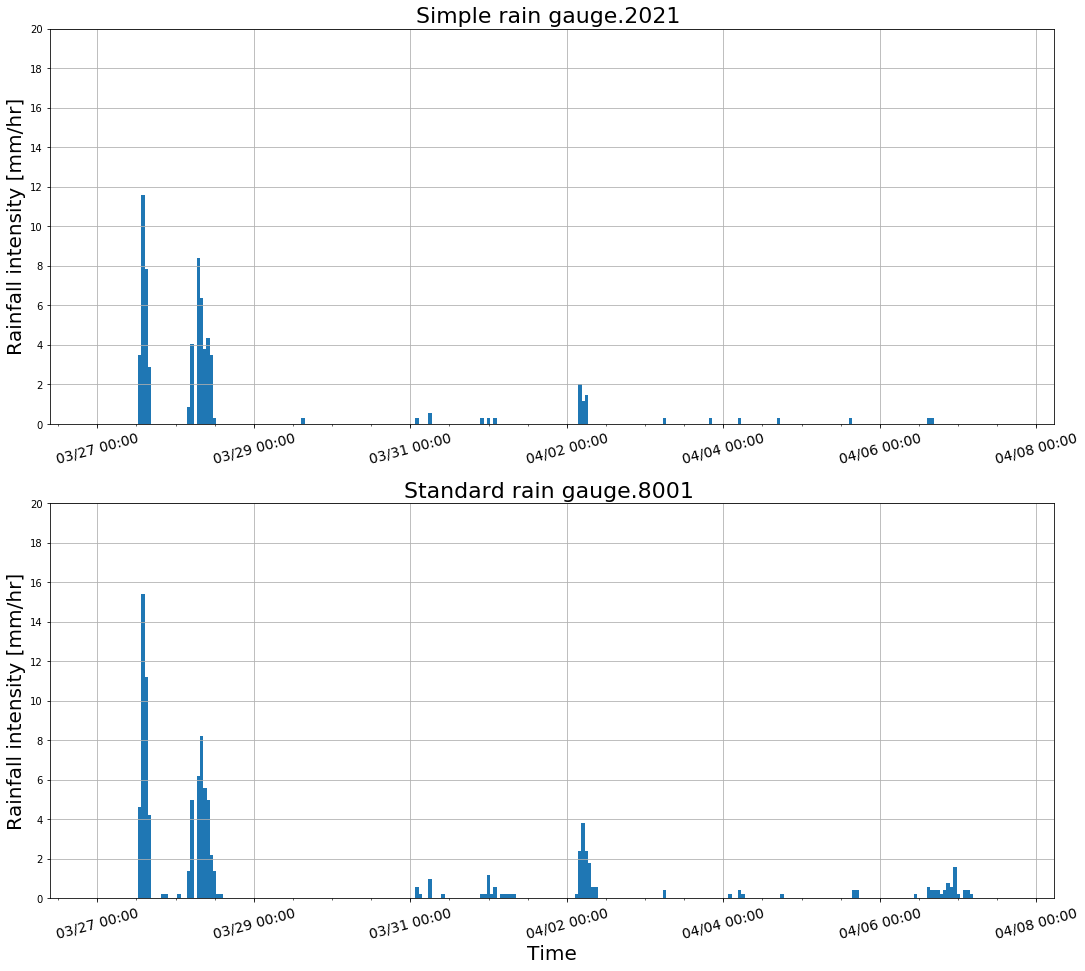

In [3]:
# Bar chart analysis
fig = plt.figure(num=1, figsize=[18,16])

upperbound = 20.01
stepValue  = 2 # Unit in mm/hr

plt.subplot(2, 1, 1)
ax1 = plt.subplot(211)
plt.bar(rainDf_hour.index, rainDf_hour['rainfall'], width = 0.045)

ax1.set_title('Simple rain gauge.2021 ', fontdict = {'fontsize':22})
#ax1.set_xlabel("Time", fontsize = 12)
ax1.set_ylabel("Rainfall intensity [mm/hr]", fontsize = 20)
plt.ylim(0, 3.01)
plt.yticks(np.arange(0, upperbound, step= stepValue))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.xticks(rotation = 30)
minorLocator = MultipleLocator(0.5)
ax1.xaxis.set_minor_locator(minorLocator)
plt.xticks(rotation = 15, fontsize= 14)
ax1.grid()


plt.subplot(2, 1, 2)
ax2 = plt.subplot(212, sharex = ax1)
ax2.set_title('Standard rain gauge.8001 ', fontdict = {'fontsize':22})
plt.bar(rainDf_hour_rpi.index, rainDf_hour_rpi['rainfall'], width = 0.045)

ax2.set_xlabel("Time", fontsize = 20)
ax2.set_ylabel("Rainfall intensity [mm/hr]", fontsize = 20)
plt.ylim(0, 3.01)
plt.yticks(np.arange(0, upperbound, step= stepValue))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.xticks(rotation = 15, fontsize= 14)

minorLocator = MultipleLocator(0.5)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.grid()

now = strftime("%Y%m%d%H%M%S")
fig.savefig('comparisonRainfall_' + '_' + now +'.jpg', dpi= 400)

D:\PythonProgm\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


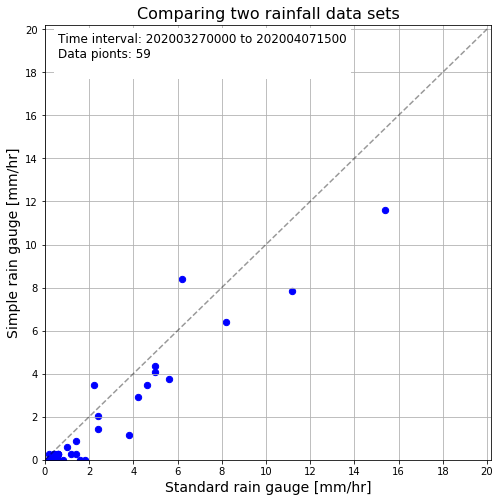

In [4]:
# Scatter analysis
def scatter_plot(Xdata, Ydata, sT, eT, rag):
    
    fig = plt.figure(num=1, figsize=[8,8])
    flagBool = Xdata > 0
    for ii in range(0, len(flagBool)):
        if flagBool[ii]:
            plt.scatter(Xdata[ii], Ydata[ii], marker = 'o', facecolors='b', edgecolors='b', alpha = 1, s = 40)
    plt.subplot(1, 1, 1)
    ax1 = plt.subplot(111)
    ax1.set_title("Comparing two rainfall data sets",fontsize = 16)
    ax1.grid()

    plt.plot([0, upperbound],[0, upperbound],'k--', alpha = 0.4)
    
    if (len(Xdata) == len(Ydata)):        
        ax1.text( rag * 0.03, rag * 0.90,
                 "Time interval: {} to {}\n".format(sT, eT) +
                 "Data pionts: {}\n".format(sum(Xdata > 0)),
                 fontsize = 12, 
                 bbox = dict(facecolor="white", alpha = 1, edgecolor = "none" )) 
    else:
        print("The data pionts between X and Y is inconsistent. ")
    
    ragAdd = rag * 0.01
    plt.ylim([0, rag + ragAdd])
    plt.xlim([0, rag + ragAdd])
    plt.yticks(np.arange(0, rag+ ragAdd, step = 2))
    plt.xticks(np.arange(0, rag+ ragAdd, step = 2))
    plt.ylabel('Simple rain gauge [mm/hr]', fontdict = {'fontsize':14})
    plt.xlabel('Standard rain gauge [mm/hr]', fontdict = {'fontsize':14})
    
    now = strftime("%Y%m%d%H%M")
    fig.savefig('outlier_scatter_ana' + '_' + now +'.jpg', dpi= 400)

scatter_plot(rainDf_hour_rpi["rainfall"], rainDf_hour["rainfall"], 
             rainDf_hour_rpi.index[0].strftime("%Y%m%d%H%M"), rainDf_hour_rpi.index[-1].strftime("%Y%m%d%H%M"),
             20)

In [76]:
len(rainDf_hour_rpi["rainfall"] > 0)

20

In [91]:
rainDf_hour_rpi["rainfall"] > 0

2020-03-27 00:00:00    False
2020-03-27 01:00:00    False
2020-03-27 02:00:00    False
2020-03-27 03:00:00    False
2020-03-27 04:00:00    False
2020-03-27 05:00:00    False
2020-03-27 06:00:00    False
2020-03-27 07:00:00    False
2020-03-27 08:00:00    False
2020-03-27 09:00:00    False
2020-03-27 10:00:00    False
2020-03-27 11:00:00    False
2020-03-27 12:00:00    False
2020-03-27 13:00:00     True
2020-03-27 14:00:00     True
2020-03-27 15:00:00     True
2020-03-27 16:00:00     True
2020-03-27 17:00:00    False
2020-03-27 18:00:00    False
2020-03-27 19:00:00    False
Freq: H, Name: rainfall, dtype: bool

In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(rainDf_hour_rpi)
    print(rainDf_hour_rpi.info())

                       id  rainfall
2019-12-01 00:00:00  8001       0.0
2019-12-01 01:00:00  8001       0.0
2019-12-01 02:00:00  8001       0.0
2019-12-01 03:00:00  8001       0.0
2019-12-01 04:00:00  8001       0.0
2019-12-01 05:00:00  8001       0.0
2019-12-01 06:00:00  8001       0.0
2019-12-01 07:00:00  8001       0.0
2019-12-01 08:00:00  8001       0.0
2019-12-01 09:00:00  8001       0.0
2019-12-01 10:00:00  8001       0.0
2019-12-01 11:00:00  8001       0.0
2019-12-01 12:00:00  8001       0.0
2019-12-01 13:00:00  8001       0.0
2019-12-01 14:00:00  8001       0.0
2019-12-01 15:00:00  8001       0.0
2019-12-01 16:00:00  8001       0.0
2019-12-01 17:00:00  8001       0.0
2019-12-01 18:00:00  8001       0.0
2019-12-01 19:00:00  8001       0.0
2019-12-01 20:00:00  8001       0.0
2019-12-01 21:00:00  8001       0.0
2019-12-01 22:00:00  8001       0.0
2019-12-01 23:00:00  8001       0.0
2019-12-02 00:00:00  8001       0.0
2019-12-02 01:00:00  8001       0.0
2019-12-02 02:00:00  8001   